## ESA Landcover

In this notebook, ESA Landcover datasets from 1992 to 2022 are processed. The following steps are included:
- Crop data for each year to research area (Germany)
- Select pixels that show needleleaved, broadleaved and mixed forest and save to new datasets
- Count pixels of each forest type per year
- Calculate forest area per year
- Plot evolution of forest types across years

In [15]:
# import libraries
import os
import xarray as xr
import rioxarray as rioxr
import geopandas as gpd
import rasterio
import odc.stac

In [16]:
# set working directory
os.chdir("E:/Master/Thesis/3_Data")
print("Current working directory: {0}".format(os.getcwd()))

Current working directory: E:\Master\Thesis\3_Data


In [17]:
# load landcover dataset of one year as example
lc_1992 = xr.open_dataset("./Raw/LC_ESA/ESACCI-LC-L4-LCCS-Map-300m-P1Y-1992-v2.0.7cds.area-subset.55.2.15.2.47.5.45.nc", 
                     decode_coords="all", 
                     decode_times=True)

In [18]:
# look at dataset
lc_1992

<xarray.Dataset>
Dimensions:              (time: 1, lat: 2952, lon: 3510, bounds: 2)
Coordinates:
    lat_bounds           (lat, bounds) float64 ...
    lon_bounds           (lon, bounds) float64 ...
    time_bounds          (time, bounds) datetime64[ns] ...
  * lat                  (lat) float64 55.2 55.2 55.19 55.19 ... 47.01 47.0 47.0
  * lon                  (lon) float64 5.451 5.454 5.457 ... 15.19 15.2 15.2
  * time                 (time) datetime64[ns] 1992-01-01
Dimensions without coordinates: bounds
Data variables:
    lccs_class           (time, lat, lon) uint8 ...
    processed_flag       (time, lat, lon) float32 ...
    current_pixel_state  (time, lat, lon) float32 ...
    observation_count    (time, lat, lon) uint16 ...
    change_count         (time, lat, lon) uint8 ...
    crs                  int32 ...
Attributes: (12/38)
    id:                         ESACCI-LC-L4-LCCS-Map-300m-P1Y-1992-v2.0.7cds
    title:                      Land Cover Map of ESA CCI brokered by CDS
    summary:                    This dataset characterizes the land cover of ...
    type:                       ESACCI-LC-L4-LCCS-Map-300m-P1Y
    project:                    Climate Change Initiative - European Space Ag...
    references:                 http://www.esa-landcover-cci.org/
    ...                         ...
    geospatial_lon_max:         180
    spatial_resolution:         300m
    geospatial_lat_units:       degrees_north
    geospatial_lat_resolution:  0.002778
    geospatial_lon_units:       degrees_east
    geospatial_lon_resolution:  0.002778

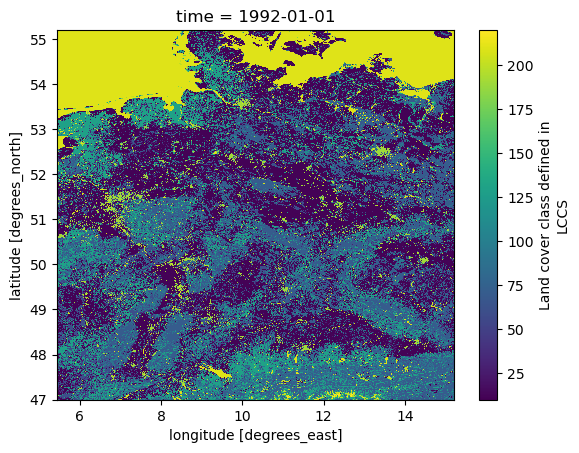

In [19]:
# plot dataset to get a first impression
lc_1992.lccs_class.plot()

In [20]:
# check crs
lc_1992.rio.crs

In [21]:
# the crs has not been defined - define it manually
lc_1992.rio.write_crs(4326, inplace=True)

<xarray.Dataset>
Dimensions:              (time: 1, lat: 2952, lon: 3510, bounds: 2)
Coordinates:
    lat_bounds           (lat, bounds) float64 ...
    lon_bounds           (lon, bounds) float64 ...
    time_bounds          (time, bounds) datetime64[ns] ...
  * lat                  (lat) float64 55.2 55.2 55.19 55.19 ... 47.01 47.0 47.0
  * lon                  (lon) float64 5.451 5.454 5.457 ... 15.19 15.2 15.2
  * time                 (time) datetime64[ns] 1992-01-01
    spatial_ref          int32 0
Dimensions without coordinates: bounds
Data variables:
    lccs_class           (time, lat, lon) uint8 ...
    processed_flag       (time, lat, lon) float32 ...
    current_pixel_state  (time, lat, lon) float32 ...
    observation_count    (time, lat, lon) uint16 ...
    change_count         (time, lat, lon) uint8 ...
    crs                  int32 ...
Attributes: (12/38)
    id:                         ESACCI-LC-L4-LCCS-Map-300m-P1Y-1992-v2.0.7cds
    title:                      Land Cover Map of ESA CCI brokered by CDS
    summary:                    This dataset characterizes the land cover of ...
    type:                       ESACCI-LC-L4-LCCS-Map-300m-P1Y
    project:                    Climate Change Initiative - European Space Ag...
    references:                 http://www.esa-landcover-cci.org/
    ...                         ...
    geospatial_lon_max:         180
    spatial_resolution:         300m
    geospatial_lat_units:       degrees_north
    geospatial_lat_resolution:  0.002778
    geospatial_lon_units:       degrees_east
    geospatial_lon_resolution:  0.002778

In [22]:
# check crs again
lc_1992.rio.crs

CRS.from_epsg(4326)

In [23]:
# load Germany shapefile 
ger = gpd.read_file("./GER.shp")

<Axes: >

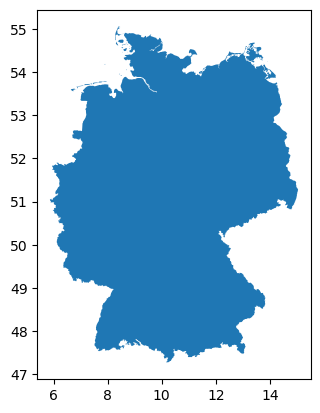

In [24]:
# look at shapefile
ger.plot()

In [25]:
# check if crs matches landcover data
ger.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [26]:
# create mask of research area using the dimensions of the exemplary landcover data
ger_mask = rasterio.features.geometry_mask(ger.geometry, 
                                               out_shape=lc_1992.odc.geobox.shape,
                                               transform=lc_1992.odc.geobox.affine,
                                               all_touched=False,
                                               invert=False)

In [27]:
ger_mask = xr.DataArray(ger_mask, dims=("lat", "lon"))

In [28]:
# create loop to process ESA Landcover data for each year
for year in range(1992, 2023):

    # open netCDF dataset of corresponding year
    directory = "./Raw/LC_ESA/"
    for file in os.listdir(directory):
        if str(year) in file and file.endswith(".nc"):
            print(f"File found for {year}: {file}")
            lc = xr.open_dataset(os.path.join(directory, file), decode_coords = "all", decode_times = True)

    # define crs
    lc.rio.write_crs(4326, inplace = True)

    # apply mask of research area to landcover dataset 
    lc_ger = lc.where(~ger_mask)

    # create mask to only select forest  from lccs_class
    # 50 (tree cover, broadleaved, evergreen)
    # 60 (tree cover, broadleaved, deciduous)
    # 70 (tree cover, needleleaved, evergreen)
    # 80 (tree cover, needleleaved, deciduous)
    # 90 (tree cover, mixed leaf)
    forest = lc_ger['lccs_class'].isin([50, 60, 70, 80, 90]).compute()

    # apply mask to lc data
    # only keep variable "lccs_class" to reduce data size
    lc_forest = lc_ger["lccs_class"].where(forest, drop=False)

    # save as netcdf data
    filename = f"Forest_GER_{year}.nc"
    lc_forest.to_netcdf(f"./Forest_GER/{filename}")

    # print status
    print(f"File for year {year} processed.")

File found for 1992: ESACCI-LC-L4-LCCS-Map-300m-P1Y-1992-v2.0.7cds.area-subset.55.2.15.2.47.5.45.nc
File for year 1992 processed.
File found for 1993: ESACCI-LC-L4-LCCS-Map-300m-P1Y-1993-v2.0.7cds.area-subset.55.2.15.2.47.5.45.nc
File for year 1993 processed.
File found for 1994: ESACCI-LC-L4-LCCS-Map-300m-P1Y-1994-v2.0.7cds.area-subset.55.2.15.2.47.5.45.nc
File for year 1994 processed.
File found for 1995: ESACCI-LC-L4-LCCS-Map-300m-P1Y-1995-v2.0.7cds.area-subset.55.2.15.2.47.5.45.nc
File for year 1995 processed.
File found for 1996: ESACCI-LC-L4-LCCS-Map-300m-P1Y-1996-v2.0.7cds.area-subset.55.2.15.2.47.5.45.nc
File for year 1996 processed.
File found for 1997: ESACCI-LC-L4-LCCS-Map-300m-P1Y-1997-v2.0.7cds.area-subset.55.2.15.2.47.5.45.nc
File for year 1997 processed.
File found for 1998: ESACCI-LC-L4-LCCS-Map-300m-P1Y-1998-v2.0.7cds.area-subset.55.2.15.2.47.5.45.nc
File for year 1998 processed.
File found for 1999: ESACCI-LC-L4-LCCS-Map-300m-P1Y-1999-v2.0.7cds.area-subset.55.2.15.2.4

In [29]:
# load one processed dataset as example and plot to get an overview
forest_1992 = xr.open_dataarray("./Forest_GER/Forest_GER_1992.nc", decode_coords = "all", decode_times= True)
forest_1992

c:\Users\irish\miniconda3\envs\KFF_SoSe23\Lib\site-packages\xarray\backends\api.py:740: UserWarning: Variable(s) referenced in bounds not in variables: ['lat_bounds']
  dataset = open_dataset(
c:\Users\irish\miniconda3\envs\KFF_SoSe23\Lib\site-packages\xarray\backends\api.py:740: UserWarning: Variable(s) referenced in bounds not in variables: ['lon_bounds']
  dataset = open_dataset(
c:\Users\irish\miniconda3\envs\KFF_SoSe23\Lib\site-packages\xarray\backends\api.py:740: UserWarning: Variable(s) referenced in bounds not in variables: ['time_bounds']
  dataset = open_dataset(


<xarray.DataArray 'lccs_class' (time: 1, lat: 2952, lon: 3510)>
[10361520 values with dtype=float64]
Coordinates:
  * lat          (lat) float64 55.2 55.2 55.19 55.19 ... 47.01 47.01 47.0 47.0
  * lon          (lon) float64 5.451 5.454 5.457 5.46 ... 15.19 15.19 15.2 15.2
  * time         (time) datetime64[ns] 1992-01-01
    spatial_ref  int32 ...
Attributes:
    standard_name:        land_cover_lccs
    flag_colors:          #ffff64 #ffff64 #ffff00 #aaf0f0 #dcf064 #c8c864 #00...
    long_name:            Land cover class defined in LCCS
    valid_min:            1
    valid_max:            220
    ancillary_variables:  processed_flag current_pixel_state observation_coun...
    flag_meanings:        no_data cropland_rainfed cropland_rainfed_herbaceou...
    flag_values:          [  0  10  11  12  20  30  40  50  60  61  62  70  7...

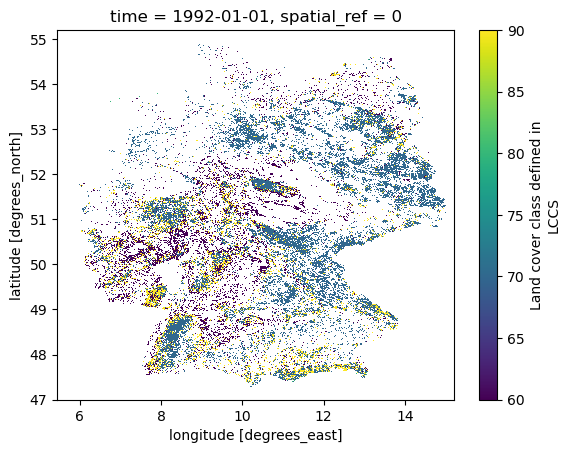

In [30]:
forest_1992.plot()